## TensorFlow model generation

This is a regular notebook structure - run each cell in order

In [2]:
import os, random, pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from shared_project_functions import get_target_subdirectory

In [16]:
# Reproducibility (good default)
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# cuDNN autotune: on for fixed shapes (turn off if seq lens vary)
torch.backends.cudnn.benchmark = True

Device: cuda


### Preprocessed data loading

Provide model name - must be the same as what you used in preprocessing step

In [3]:
base_corpus = "shakespeare"

dir = get_target_subdirectory(base_corpus, subdir_string="model")

#Load preprocessed data from subdirectory
with open(f"{dir}/{base_corpus}_preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)
    X_train = data["X_train"]
    y_train = data["y_train"]
    word_to_id = data["word_to_id"]
    id_to_word = data["id_to_word"],
    max_seq_length = data["max_seq_length"]

In [8]:
# Check and choose devices
print("CUDA is available: ", torch.cuda.is_available())
if torch.cuda.is_available:
    print("Number of CUDA devices: ", torch.cuda.device_count())
    print("Current CUDA device number: ", torch.cuda.current_device())
    print("Current CUDA device name: ", torch.cuda.get_device_name(0))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device chossen:", device)

CUDA is available:  True
Number of CUDA devices:  1
Current CUDA device number:  0
Current CUDA device name:  NVIDIA GeForce GTX 1070 Ti
Device chossen: cuda


In [9]:
# Hyperparameters
vocab_size      = len(word_to_id)     # from your preprocessing
embedding_dim   = 256
rnn_units       = 1024
dropout         = 0.2
max_seq_length  = max_seq_length      # from your preprocessing
batch_size      = 128
epochs          = 10
base_corpus     = base_corpus         # e.g., "shakespeare"

In [10]:
# Data conversion: Numpy → Torch tensors → DataLoader
# Expect: X_train shape (N, max_seq_length) of int ids; y_train shape (N,) of int class ids
x_train_np = np.array(X_train, dtype=np.int64)
y_train_np = np.array(y_train, dtype=np.int64)

x_train = torch.tensor(x_train_np, dtype=torch.long)
y_train = torch.tensor(y_train_np, dtype=torch.long)

train_ds = TensorDataset(x_train, y_train)

num_workers = min(4, os.cpu_count() or 1)
pin = torch.cuda.is_available()

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin,
    persistent_workers=bool(num_workers)
)

len(train_ds), next(iter(train_loader))[0].shape

/tmp/ipykernel_16150/1640063483.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_train_np = np.array(y_train, dtype=np.int64)


(1100120, torch.Size([128, 20]))

In [13]:
# Model
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_units, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=rnn_units, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=rnn_units, hidden_size=rnn_units, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(rnn_units, vocab_size)  # logits over vocab (no softmax)

    def forward(self, x):
        x = self.embedding(x)                 # (B, T, E)
        x, _ = self.lstm1(x)                  # (B, T, H)
        x = self.dropout1(x)
        x, (h_n, _) = self.lstm2(x)          # h_n: (1, B, H)
        last_hidden = h_n[-1]                 # (B, H) — matches Keras final LSTM output
        last_hidden = self.dropout2(last_hidden)
        return self.fc(last_hidden)           # (B, vocab)

model = TextLSTM(vocab_size, embedding_dim, rnn_units, dropout).to(device)

# Info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters: total={total_params:,} trainable={trainable_params:,}")

Parameters: total=36,612,359 trainable=36,612,359


In [18]:
# Optimizer & loss (Keras compile analog)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()  # expects raw logits + integer class targets

In [20]:
# Train function (Keras-like)
def fit(model, loader, optimizer, criterion, epochs=10, device="cpu",
        grad_clip=None, use_tqdm=True, log_interval=50):
    """
    Trains the model and returns a Keras-like history dict.
    - Shows "Epoch i/n" and an in-epoch progress bar (if tqdm available).
    - Updates the bar with running loss & accuracy.
    - Falls back to periodic prints if tqdm isn't installed.
    """
    try:
        from tqdm.auto import tqdm
    except Exception:
        tqdm = None
        use_tqdm = False

    history = {"loss": [], "accuracy": []}
    num_batches = len(loader)

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        if use_tqdm and tqdm is not None:
            pbar = tqdm(total=num_batches, desc=f"Epoch {epoch}/{epochs}",
                        leave=True, dynamic_ncols=True)
        else:
            print(f"\nEpoch {epoch}/{epochs}")

        for step, (xb, yb) in enumerate(loader, start=1):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            # running stats
            bs = yb.size(0)
            running_loss += loss.item() * bs
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total += bs

            avg_loss = running_loss / max(total, 1)
            avg_acc  = correct / max(total, 1)
            # (optional) current LR (assumes one param group)
            lr = optimizer.param_groups[0].get("lr", None)

            if use_tqdm and tqdm is not None:
                if lr is None:
                    pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.4f}")
                else:
                    pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.4f}", lr=f"{lr:.2e}")
                pbar.update(1)
            else:
                # plain prints every log_interval steps and at the end
                if (step % log_interval == 0) or (step == num_batches):
                    pct = 100.0 * step / num_batches
                    if lr is None:
                        print(f"  [{step:>5}/{num_batches}] {pct:6.2f}%  "
                              f"loss={avg_loss:.4f}  acc={avg_acc:.4f}")
                    else:
                        print(f"  [{step:>5}/{num_batches}] {pct:6.2f}%  "
                              f"loss={avg_loss:.4f}  acc={avg_acc:.4f}  lr={lr:.2e}")

        # end epoch
        epoch_loss = running_loss / max(total, 1)
        epoch_acc  = correct / max(total, 1)
        history["loss"].append(epoch_loss)
        history["accuracy"].append(epoch_acc)

        if use_tqdm and tqdm is not None:
            pbar.close()
        # Final epoch summary line (useful even with tqdm)
        print(f"Epoch {epoch}/{epochs} — loss: {epoch_loss:.4f} — acc: {epoch_acc:.4f}")

    return history



In [21]:
# Run training
history = fit(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    device=device,
    grad_clip=None  # e.g., set to 1.0 if you see exploding grads
)

/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/10: 100%|██████████| 8595/8595 [09:56<00:00, 14.40it/s, acc=0.1615, loss=5.6016, lr=1.00e-03]


Epoch 1/10 — loss: 5.6016 — acc: 0.1615


Epoch 2/10: 100%|██████████| 8595/8595 [09:55<00:00, 14.42it/s, acc=0.1845, loss=5.2405, lr=1.00e-03]


Epoch 2/10 — loss: 5.2405 — acc: 0.1845


Epoch 3/10: 100%|██████████| 8595/8595 [09:55<00:00, 14.43it/s, acc=0.1937, loss=5.0747, lr=1.00e-03]


Epoch 3/10 — loss: 5.0747 — acc: 0.1937


Epoch 4/10: 100%|██████████| 8595/8595 [09:56<00:00, 14.42it/s, acc=0.2005, loss=4.9516, lr=1.00e-03]


Epoch 4/10 — loss: 4.9516 — acc: 0.2005


Epoch 5/10: 100%|██████████| 8595/8595 [09:55<00:00, 14.42it/s, acc=0.2065, loss=4.8462, lr=1.00e-03]


Epoch 5/10 — loss: 4.8462 — acc: 0.2065


Epoch 6/10: 100%|██████████| 8595/8595 [09:56<00:00, 14.42it/s, acc=0.2121, loss=4.7498, lr=1.00e-03]


Epoch 6/10 — loss: 4.7498 — acc: 0.2121


Epoch 7/10: 100%|██████████| 8595/8595 [09:56<00:00, 14.42it/s, acc=0.2172, loss=4.6578, lr=1.00e-03]


Epoch 7/10 — loss: 4.6578 — acc: 0.2172


Epoch 8/10: 100%|██████████| 8595/8595 [09:53<00:00, 14.47it/s, acc=0.2225, loss=4.5718, lr=1.00e-03]


Epoch 8/10 — loss: 4.5718 — acc: 0.2225


Epoch 9/10: 100%|██████████| 8595/8595 [09:53<00:00, 14.49it/s, acc=0.2273, loss=4.4936, lr=1.00e-03]


Epoch 9/10 — loss: 4.4936 — acc: 0.2273


Epoch 10/10: 100%|██████████| 8595/8595 [09:57<00:00, 14.40it/s, acc=0.2320, loss=4.4197, lr=1.00e-03]

Epoch 10/10 — loss: 4.4197 — acc: 0.2320


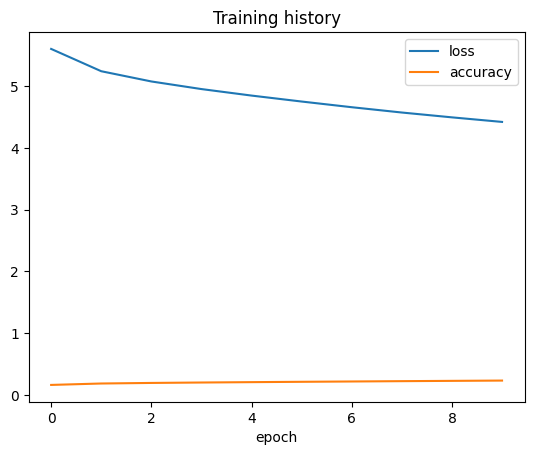

In [22]:
# Cell 8 — Plot training curves (optional)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["loss"], label="loss")
plt.plot(history["accuracy"], label="accuracy")
plt.xlabel("epoch"); plt.legend(); plt.title("Training history")
plt.show()

In [23]:
# Cell 9 — Save artifacts
model_path = f"{base_corpus}_model.pt"
hist_path  = f"{base_corpus}_training_history.pkl"

torch.save(model.state_dict(), model_path)
with open(hist_path, "wb") as f:
    pickle.dump(history, f)

print("Saved:", model_path, "and", hist_path)

Saved: shakespeare_model.pt and shakespeare_training_history.pkl


In [14]:
# Define model

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# # Model hyperparameters
# vocab_size = len(word_to_id)
# embedding_dim = 256  # The size of the word vectors
# rnn_units = 1024     # The number of units in the LSTM layer
# dropout = 0.2       # Dropout rate for regularization

# model = Sequential([
#     # Embedding layer: Converts integer IDs to dense vectors
#     Embedding(input_dim=vocab_size,
#               output_dim=embedding_dim,
#               input_length=max_seq_length),

#     # LSTM layer: The core of the model for learning sequence patterns
#     LSTM(rnn_units, return_sequences=True),
#     Dropout(dropout), # Dropout for regularization

#     LSTM(rnn_units),
#     Dropout(dropout), # Another dropout layer

#     # Dense layer: Maps the LSTM output to the vocabulary
#     Dense(vocab_size, activation='softmax')
# ])

In [15]:
# # Compile model
# from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError

# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss=SparseCategoricalCrossentropy(),
#     metrics=['accuracy']
# )

# # Print a summary of model to see layers and parameter count
# model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# # Convert training lists to numpy arrays
# x_train_np = np.array(X_train)
# y_train_np = np.array(y_train)


# # Train the model and save the training history
# history = model.fit(
#     x_train_np,
#     y_train_np,
#     epochs=10,
#     batch_size=128
# )

# # Save the trained model
# model.save(f"{base_corpus}_model.keras")

# #Save the training history to subdirectory
# with open(f"{base_corpus}_training_history.pkl", "wb") as f:
#     pickle.dump(history.history, f)

Epoch 1/10


E0000 00:00:1758040683.880033    3654 dnn.cc:935] CUDNN_STATUS_EXECUTION_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(2039): 'cudnnRNNForward( cudnn.handle(), rnn_desc.handle(), rnn_fwd_mode, reinterpret_cast<const int*>(seq_lengths_data.opaque()), input_desc.data_handle(), input_data.opaque(), output_desc.data_handle(), output_data->opaque(), input_h_desc.handle(), input_h_data.opaque(), output_h_data->opaque(), input_c_desc.handle(), input_c_data.opaque(), output_c_data->opaque(), rnn_desc.ParamsSizeInBytes(), params.opaque(), workspace.size(), workspace.opaque(), reserve_space.size(), reserve_space.opaque())'
2025-09-16 12:38:03.880070: W tensorflow/core/framework/op_kernel.cc:1855] OP_REQUIRES failed at cudnn_rnn_ops.cc:1776 : INTERNAL: Failed to call DoRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 256, 1024, 1, 20, 128, 1024

InternalError: Graph execution error:

Detected at node sequential_1_1/lstm_2_1/CudnnRNNV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.13/asyncio/base_events.py", line 683, in run_forever

  File "/usr/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once

  File "/usr/lib/python3.13/asyncio/events.py", line 89, in _run

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 519, in dispatch_queue

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 508, in process_one

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 368, in execute_request

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 455, in do_execute

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 577, in run_cell

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code

  File "/tmp/ipykernel_3505/1792240866.py", line 7, in <module>

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/layer.py", line 941, in __call__

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/ops/operation.py", line 59, in __call__

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/models/sequential.py", line 220, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/ops/function.py", line 206, in _run_through_graph

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/models/functional.py", line 644, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/layer.py", line 941, in __call__

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/ops/operation.py", line 59, in __call__

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/lstm.py", line 583, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/lstm.py", line 550, in inner_loop

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/home/alvisngan/Documents/george_brown/math_dl/AASD4011_term_project/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

Failed to call DoRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 256, 1024, 1, 20, 128, 1024] 
	 [[{{node sequential_1_1/lstm_2_1/CudnnRNNV3}}]] [Op:__inference_multi_step_on_iterator_6374]

In [24]:
#display history
import matplotlib.pyplot as plt

#load history file from subdirectory
with open(f"{dir}/{base_corpus}_training_history.pkl", "rb") as f:
    history = pickle.load(f)
    
#Y-axis limit for loss plot
plt.ylim(0, np.ceil(max(history['loss'])))

#Tile and labels
plt.title(f'Training history for {base_corpus.capitalize()} Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history['loss'], label='loss')

FileNotFoundError: [Errno 2] No such file or directory: 'model_0_shakespeare/shakespeare_training_history.pkl'